In [11]:
import numpy as np
import pandas as pd
from IPython.display import display

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


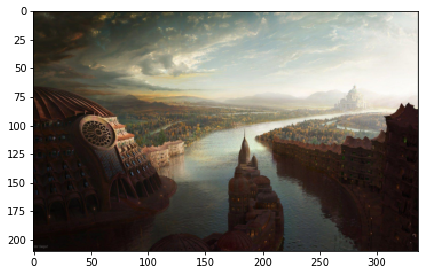

In [12]:
from skimage import io
from skimage.transform import rescale

# read our testing image in
tst_image = io.imread('./test_images/3.jpg')

# downsize the image
tst_image = rescale(tst_image, 0.2, anti_aliasing=True)

# get the number of pixels using the shape of the image
x_len = tst_image.shape[0]
y_len = tst_image.shape[1]
num_pixels = x_len * y_len

io.imshow(tst_image)

In [13]:
# reshape so it's a 2d array
X_reshaped = tst_image.reshape(num_pixels, 3)
print(X_reshaped.shape)
print(X_reshaped)

(70560, 3)
[[0.08627451 0.08235294 0.06666667]
 [0.10588235 0.09411765 0.07058824]
 [0.11764706 0.10196078 0.06666667]
 ...
 [0.04705882 0.02352941 0.01568627]
 [0.0627451  0.03137255 0.02745098]
 [0.0627451  0.02745098 0.02745098]]


In [14]:
from sklearn.cluster import KMeans

# set clusters to 12, later on, we'll detect this
kmeans_mod = KMeans(n_clusters=12)
preds = kmeans_mod.fit_predict(X_reshaped)

In [15]:
def results_to_df(X_input, cluster_preds):
    concatenated = []
    for pixel, cluster in zip(X_input, cluster_preds):
        pixel = list(pixel)
        pixel.append(cluster)
        concatenated.append(pixel)
    result_df = pd.DataFrame(concatenated)
    result_df.columns = ['r', 'g', 'b', 'cluster']
    return result_df

km_result_df = results_to_df(X_reshaped, preds)
display(km_result_df)

,r,g,b,cluster
0,0.086275,0.082353,0.066667,3
1,0.105882,0.094118,0.070588,3
2,0.117647,0.101961,0.066667,9
3,0.117647,0.101961,0.062745,9
4,0.121569,0.101961,0.062745,9
...,...,...,...,...
70555,0.062745,0.027451,0.023529,3
70556,0.050980,0.023529,0.023529,3
70557,0.047059,0.023529,0.015686,3
70558,0.062745,0.031373,0.027451,3


In [16]:
def display_with_cluster_lookup(result_df, lookup):
    clusters = result_df.cluster.unique()
    for cluster in clusters:
        if cluster not in lookup:
            raise RuntimeError('no mapping for cluster "%d"' % cluster)
    result_df['colour'] = result_df['cluster'].apply(lambda c: lookup[c])
    # get just the colour
    final_img = result_df.iloc[:, -1]

    # cast to np array
    final_img = np.array([np.array(arr) for arr in final_img])
    
    # reshape back to the original image size
    final_img = final_img.reshape(x_len, y_len, 3)

    io.imshow(final_img)

# map clusters to a colour
cluster_to_colour = {
    0: [219, 138, 116],
    1: [250, 201, 184],
    2: [47, 36, 58],
    3: [68, 64, 84],
    4: [190, 187, 187],
    5: [73, 159, 104],
}

# display_with_cluster_lookup(km_result_df, cluster_to_colour)

In [17]:
def get_cluster_averages(result_df):
    """
    
    :param result_df: Output df from results_to_df method. 
    :return: Lookup dictionary with the average colour for each entry.
    """
    cluster_colour_avg = {}
    cluster_labels = result_df.cluster.unique()
    
    for cluster in cluster_labels:
        # get only the cluster instances from the df
        cluster_instances = result_df[result_df.cluster == cluster]
        instance_colours = cluster_instances.iloc[:, 0:3].values
        num_cluster_instances = len(instance_colours)
        summed_colours = [0, 0, 0]
        for instance_colour in instance_colours:
            summed_colours += instance_colour
        average_colour = [channel / num_cluster_instances for channel in summed_colours]
        cluster_colour_avg[cluster] = average_colour
    
    return cluster_colour_avg

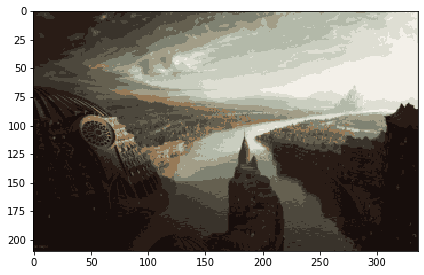

In [18]:
kmeans_colour_lookup = get_cluster_averages(km_result_df)
display_with_cluster_lookup(km_result_df, kmeans_colour_lookup)

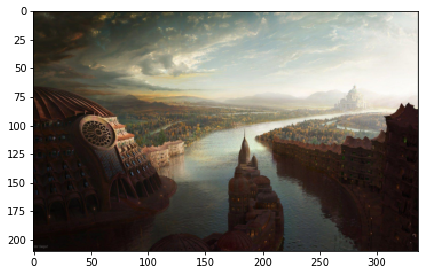

In [19]:
io.imshow(tst_image)


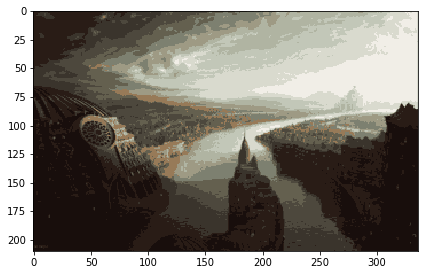

In [21]:
from sklearn.cluster import DBSCAN

db_mod = DBSCAN()
db_preds = db_mod.fit_predict(X_reshaped)
db_results_df = results_to_df(X_reshaped, db_preds)
db_colour_lookup = get_cluster_averages(db_results_df)
display_with_cluster_lookup(db_results_df, db_colour_lookup)